In [24]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import copy
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2
from tensorflow.keras import optimizers
import pickle
from numpy.linalg import norm

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [26]:
!wget https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_net.h5

--2022-05-01 16:32:15--  https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_net.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_net.h5 [following]
--2022-05-01 16:32:16--  https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_net.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7274924 (6.9M) [application/octet-stream]
Saving to: ‘sunglasses_bd_net.h5.1’

sunglass

In [27]:
!wget https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_weights.h5

--2022-05-01 16:32:17--  https://github.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/raw/main/models/sunglasses_bd_weights.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_weights.h5 [following]
--2022-05-01 16:32:18--  https://raw.githubusercontent.com/vbabushkin/ECE_GY_9163_Machine_Learning_for_Cyber_Security_Project/main/models/sunglasses_bd_weights.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2442796 (2.3M) [application/octet-stream]
Saving to: ‘sunglasses_bd_weights

In [28]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [29]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [30]:
def visualize_data(X,y,num_samples=10000):
  num = 10
  np.random.seed(45)
  randIdx = [np.random.randint(num_samples) for i in range(num)]
  num_row = 2
  num_col = 5# plot images
  fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(X[randIdx[i]].astype('uint8'))
      ax.set_title('label: {:.0f}'.format(y[randIdx[i]]))
      ax.set_xticks([])
      ax.set_yticks([])
  plt.tight_layout()
  plt.show()

In [34]:
#define data path
data_path="/content/drive/MyDrive/fine-pruning/data/Lab3"
cl_valid_filename = data_path+"/cl/valid.h5"
cl_test_filename = data_path+"/cl/test.h5"
bd_valid_filename = data_path+"/bd/bd_valid.h5"
bd_test_filename = data_path+"/bd/bd_test.h5"

# define model paths
model_folder="/content/drive/MyDrive/fine-pruning/models"
# bd_model_path = model_folder+"/bd_net.h5"
# bd_model_weights_path = model_folder+"/bd_weights.h5"

bd_model_path = "/content/sunglasses_bd_net.h5"
bd_model_weights_path = "/content/sunglasses_bd_weights.h5"


fp_model_path = model_folder+"/bd_net_tmp.h5"
fp_model_weights_path = model_folder+"/bd_weights_tmp.h5"


#Load model in memory
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bd_model = tf.keras.models.load_model(bd_model_path)
bd_model.load_weights(bd_model_weights_path)
fp_model =tf.keras.models.load_model(fp_model_path)
fp_model.load_weights(fp_model_weights_path)


#Load data in memory
cl_x_valid, cl_y_valid = data_loader(cl_valid_filename)
cl_x_test, cl_y_test = data_loader(cl_test_filename)
bd_x_valid, bd_y_valid = data_loader(bd_valid_filename)
bd_x_test, bd_y_test = data_loader(bd_test_filename)



In [32]:
def thresholdbyact(X,model,layer_idx,norm_ord,debug = True):
  tmp = Model(model.inputs, outputs=model.layers[layer_idx].output)
  fmaps=tmp(X)
  norms = []
  num_filters = fmaps.shape[-1]
  for i in range(num_filters):
    norms.append(tf.norm(fmaps[:,:,:,i],ord=norm_ord).numpy())
  mean_norm = np.array(norms).mean()
  if debug == True:
    print("Mean Norm of layer : ", mean_norm)
  fidp=[]
  for i in range(num_filters):
    if debug == True:
        print("Activation of Weight ",i,": ",norms[i])

    if norms[i]<= mean_norm:    
      fidp.append(i)

  return norms,fidp

In [42]:
def visualizeActivations(model, dataset, layer_name , pathToSave, num_filters, clbLowLimit = None, clbUpLimit = None):
    lastPoolLayerIdx = getLayerIndexByName(model, layer_name)
    tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
    feature_maps = tmpModel(dataset)
    averageActivations = np.mean(feature_maps,0)
    # averageActivations = np.mean(model.layers[getLayerIndexByName(model,layer_name)].get_weights()[0],0)
    col = 10# to arrange them in 10 columns and 6 rows
    fig, axs = plt.subplots(int(num_filters / 10), 10, figsize=(10, 5), sharex=False, sharey=False)
    for i in range(averageActivations.shape[2]):
        axs[i // col, i % col].set_title('ch = '+str(i),fontsize=9, y=0.90)
        if clbLowLimit is not None and clbUpLimit is not None:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=clbLowLimit, vmax=clbUpLimit)
        else:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=np.min(averageActivations), vmax=np.max(averageActivations))
        # axs[i // col, i % col ].invert_yaxis()
        axs[i // col, i % col ].set_axis_off()
        fig.subplots_adjust(right=0.9)
    ax_x_start  = 0.92
    ax_x_width  = 0.02
    ax_y_start  = 0.13
    ax_y_height = 0.75
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im,cax=cbar_ax)
    if clbLowLimit is not None and clbUpLimit is not None:
        clb.mappable.set_clim(clbLowLimit, clbUpLimit)
    else:
        clb.mappable.set_clim(np.min(averageActivations), np.max(averageActivations))
    clb.ax.set_title('', fontsize=14)  # title on top of colorbar

    # plt.savefig(pathToSave+'.pdf')
    plt.savefig(pathToSave+'.png', dpi=800)
    # return averageActivations

In [ ]:
def visualizeWeights(model, dataset, layer_name , pathToSave, num_filters, clbLowLimit = None, clbUpLimit = None):
    # lastPoolLayerIdx = getLayerIndexByName(model, layer_name)
    # tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
    # feature_maps = tmpModel(dataset)
    # averageActivations = np.mean(feature_maps,0)
    averageActivations = np.mean(model.layers[getLayerIndexByName(model,layer_name)].get_weights()[0],0)
    col = 10# to arrange them in 10 columns and 6 rows
    fig, axs = plt.subplots(int(num_filters / 10), 10, figsize=(15, 8), sharex=False, sharey=False)
    for i in range(averageActivations.shape[2]):
        axs[i // col, i % col].set_title('ch = '+str(i),fontsize=10, y=0.95)
        if clbLowLimit is not None and clbUpLimit is not None:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=clbLowLimit, vmax=clbUpLimit)
        else:
            im = axs[i // col, i % col ].imshow(averageActivations[:,:,i],vmin=np.min(averageActivations), vmax=np.max(averageActivations))
        axs[i // col, i % col ].invert_yaxis()
        axs[i // col, i % col ].set_axis_off()
        fig.subplots_adjust(right=0.9)
    ax_x_start  = 0.92
    ax_x_width  = 0.02
    ax_y_start  = 0.13
    ax_y_height = 0.75
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im,cax=cbar_ax)
    if clbLowLimit is not None and clbUpLimit is not None:
        clb.mappable.set_clim(clbLowLimit, clbUpLimit)
    else:
        clb.mappable.set_clim(np.min(averageActivations), np.max(averageActivations))
    clb.ax.set_title('', fontsize=14)  # title on top of colorbar
  
    # plt.savefig(pathToSave+'.pdf')
    plt.savefig(pathToSave+'.png', dpi=800)
    # return averageActivations

In [ ]:
def thresholdbyfilterweights(X,model,layer_idx,norm_ord,debug = True):
  fmaps = model.layers[layer_idx].get_weights()[0]

  norms = []
  num_filters=fmaps.shape[-1]
  for i in range(num_filters):
    norms.append(tf.norm(fmaps[:,:,:,i],ord=norm_ord).numpy())
  mean_norm = np.array(norms).mean()
  if debug == True:
   print("Mean Norm of layer : ", mean_norm)
  fidp=[]
  for i in range(num_filters):
    if debug == True:
        print("Weight",i," Norm is : ",norms[i])
    if norms[i]<= mean_norm:
      fidp.append(i)
      

  return norms,fidp


In [ ]:
conv_layer_name = "conv_1"
norm_ord = "euclidean" # euclidean or 1
c1_norms , c1_idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)


Mean Norm of layer :  0.8615057
Weight 0  Norm is :  0.56461704
Weight 1  Norm is :  1.4869287
Weight 2  Norm is :  1.0561976
Weight 3  Norm is :  1.5918816
Weight 4  Norm is :  0.6599999
Weight 5  Norm is :  1.2976242
Weight 6  Norm is :  0.5369121
Weight 7  Norm is :  0.95583314
Weight 8  Norm is :  0.54521954
Weight 9  Norm is :  0.6715044
Weight 10  Norm is :  1.0202688
Weight 11  Norm is :  0.94932365
Weight 12  Norm is :  0.7667998
Weight 13  Norm is :  0.56670105
Weight 14  Norm is :  0.79803914
Weight 15  Norm is :  0.65327823
Weight 16  Norm is :  0.5357681
Weight 17  Norm is :  1.3693076
Weight 18  Norm is :  0.7094253
Weight 19  Norm is :  0.49448445


In [ ]:
np.argsort(c1_norms)

array([19,  6, 16,  8,  0, 13, 15,  9,  4, 18, 12, 14, 11,  7, 10,  2,  5,
       17,  1,  3])

In [ ]:
conv_layer_name = "conv_2"
norm_ord = "euclidean" # euclidean or 1
c3_norms , c3_idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)


Mean Norm of layer :  1.1135275
Weight 0  Norm is :  1.0927261
Weight 1  Norm is :  1.0105559
Weight 2  Norm is :  1.0825583
Weight 3  Norm is :  1.0729642
Weight 4  Norm is :  0.7925741
Weight 5  Norm is :  1.1550001
Weight 6  Norm is :  1.3249322
Weight 7  Norm is :  1.0220188
Weight 8  Norm is :  1.0411652
Weight 9  Norm is :  1.1728153
Weight 10  Norm is :  1.29553
Weight 11  Norm is :  1.0157949
Weight 12  Norm is :  1.5834167
Weight 13  Norm is :  0.95367366
Weight 14  Norm is :  1.0410466
Weight 15  Norm is :  1.2824476
Weight 16  Norm is :  1.0730743
Weight 17  Norm is :  1.1844586
Weight 18  Norm is :  0.98913974
Weight 19  Norm is :  1.1926775
Weight 20  Norm is :  0.9630479
Weight 21  Norm is :  0.9414218
Weight 22  Norm is :  1.0278488
Weight 23  Norm is :  1.0718849
Weight 24  Norm is :  1.0204369
Weight 25  Norm is :  1.352571
Weight 26  Norm is :  0.82722926
Weight 27  Norm is :  1.0949936
Weight 28  Norm is :  1.4610072
Weight 29  Norm is :  1.1724616
Weight 30  Norm is

In [ ]:
conv_layer_name = "conv_3"
norm_ord = "euclidean" # euclidean or 1
c5_norms , c5_idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)


Mean Norm of layer :  1.3386534
Weight 0  Norm is :  1.2582285
Weight 1  Norm is :  1.1589143
Weight 2  Norm is :  1.1479741
Weight 3  Norm is :  1.4714835
Weight 4  Norm is :  1.451331
Weight 5  Norm is :  1.3471066
Weight 6  Norm is :  1.8406912
Weight 7  Norm is :  1.3735986
Weight 8  Norm is :  1.3528719
Weight 9  Norm is :  1.2647984
Weight 10  Norm is :  1.554392
Weight 11  Norm is :  1.6655852
Weight 12  Norm is :  1.0274392
Weight 13  Norm is :  1.5421001
Weight 14  Norm is :  1.1703122
Weight 15  Norm is :  1.3848366
Weight 16  Norm is :  1.2073684
Weight 17  Norm is :  1.3465508
Weight 18  Norm is :  1.6477368
Weight 19  Norm is :  1.4109017
Weight 20  Norm is :  1.6037806
Weight 21  Norm is :  1.3373278
Weight 22  Norm is :  1.627698
Weight 23  Norm is :  1.322797
Weight 24  Norm is :  1.3637408
Weight 25  Norm is :  1.5544401
Weight 26  Norm is :  1.2517513
Weight 27  Norm is :  1.2106094
Weight 28  Norm is :  1.2739077
Weight 29  Norm is :  1.666236
Weight 30  Norm is :  1

In [ ]:
!mkdir weights

In [ ]:
global_norms = c1_norms+c3_norms+c5_norms

In [ ]:
np.mean(global_norms)

1.1840869

Mean Norm of layer :  12.177309
Weight 0  Norm is :  11.837303
Weight 1  Norm is :  11.018069
Weight 2  Norm is :  11.863918
Weight 3  Norm is :  12.125632
Weight 4  Norm is :  9.268538
Weight 5  Norm is :  12.826493
Weight 6  Norm is :  14.4936285
Weight 7  Norm is :  11.421001
Weight 8  Norm is :  11.00046
Weight 9  Norm is :  12.577201
Weight 10  Norm is :  14.115664
Weight 11  Norm is :  11.490646
Weight 12  Norm is :  15.982344
Weight 13  Norm is :  10.968406
Weight 14  Norm is :  11.324117
Weight 15  Norm is :  13.880738
Weight 16  Norm is :  11.677586
Weight 17  Norm is :  13.230291
Weight 18  Norm is :  11.25629
Weight 19  Norm is :  12.975637
Weight 20  Norm is :  10.5092
Weight 21  Norm is :  10.80614
Weight 22  Norm is :  11.294532
Weight 23  Norm is :  12.054807
Weight 24  Norm is :  10.786737
Weight 25  Norm is :  14.588337
Weight 26  Norm is :  9.543702
Weight 27  Norm is :  12.256194
Weight 28  Norm is :  15.407294
Weight 29  Norm is :  12.748651
Weight 30  Norm is :  11

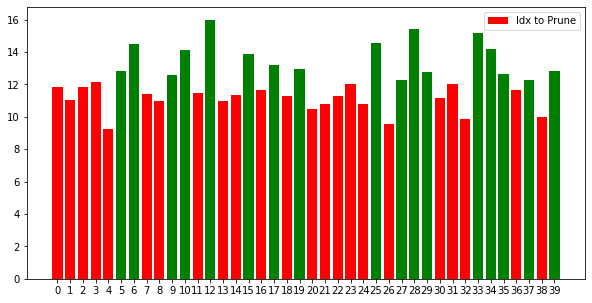

weight Idx to prune:  [0, 1, 2, 3, 4, 7, 8, 11, 13, 14, 16, 18, 20, 21, 22, 23, 24, 26, 30, 31, 32, 36, 38]


In [ ]:
conv_layer_name = "conv_2"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyfilterweights(bd_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)

idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.figure(figsize=(10, 5))
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
# plt.title("conv1: Weight vs L2 Norm")
plt.savefig("/content/weights/conv3_L1NORM")
plt.show()
print("weight Idx to prune: ",idxToPrune)


In [ ]:
 !zip -r weights.zip /content/weights

  adding: content/weights/ (stored 0%)
  adding: content/weights/conv3_L2NORM.png (deflated 18%)
  adding: content/weights/conv5_L1NORM.png (deflated 17%)
  adding: content/weights/conv1_L2NORM.png (deflated 20%)
  adding: content/weights/conv1_L1NORM.png (deflated 24%)
  adding: content/weights/.ipynb_checkpoints/ (stored 0%)
  adding: content/weights/conv5_L2NORM.png (deflated 17%)
  adding: content/weights/conv3_L1NORM.png (deflated 19%)


In [ ]:
bd_model_path = "/content/sunglasses_bd_net.h5"
bd_model_weights_path = "/content/sunglasses_bd_weights.h5"

fp_model_path = "/content/CONV3_net.h5"
fp_model_weights_path = "/content/CONV3_weights.h5"

bd_model = tf.keras.models.load_model(bd_model_path)
bd_model.load_weights(bd_model_weights_path)
fp_model = tf.keras.models.load_model(fp_model_path)
fp_model.load_weights(fp_model_weights_path)


data_path="/content/drive/MyDrive/fine-pruning/data/Lab3"
cl_valid_filename = data_path+"/cl/valid.h5"
cl_test_filename = data_path+"/cl/test.h5"
bd_valid_filename = data_path+"/bd/bd_valid.h5"
bd_test_filename = data_path+"/bd/bd_test.h5"

cl_x_valid, cl_y_valid = data_loader(cl_valid_filename)
cl_x_test, cl_y_test = data_loader(cl_test_filename)
bd_x_valid, bd_y_valid = data_loader(bd_valid_filename)
bd_x_test, bd_y_test = data_loader(bd_test_filename)


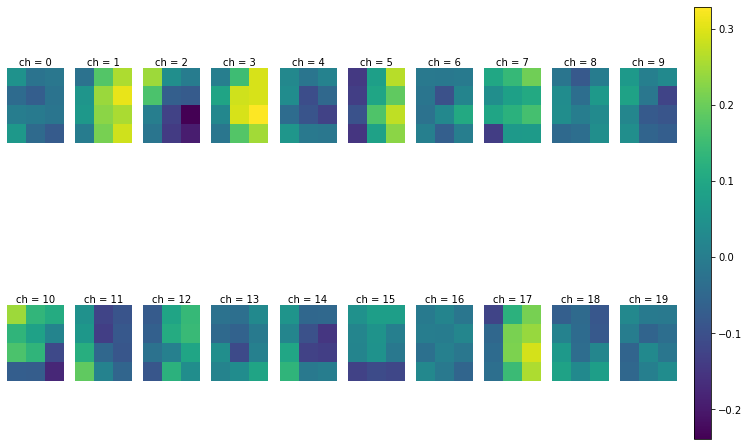

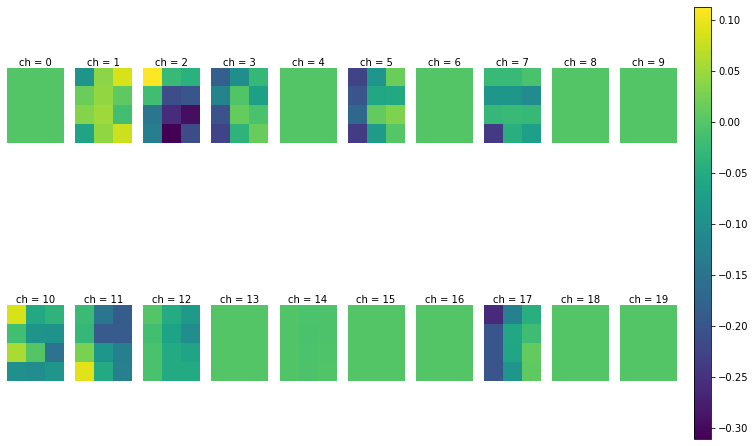

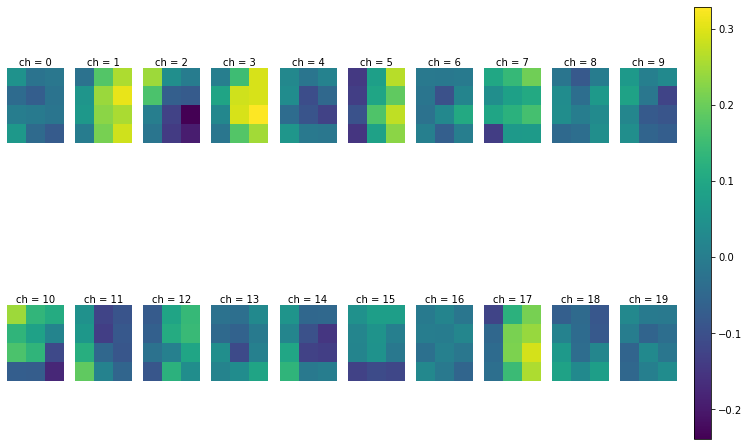

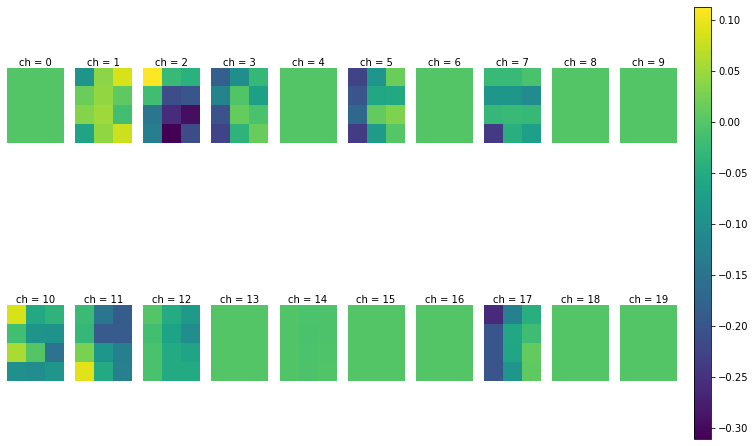

In [ ]:
# pathToSave = "/content/conv1-cl_x_test_bd_model"
# visualizeActivations(bd_model,cl_x_test,"conv_1",pathToSave,20)

# pathToSave = "/content/conv1-cl_x_test_fp_model"
# visualizeActivations(fp_model,cl_x_test,"conv_1",pathToSave,20)

# pathToSave = "/content/conv1-bd_x_test_bd_model"
# visualizeActivations(bd_model,bd_x_test,"conv_1",pathToSave,20)

# pathToSave = "/content/conv1-bd_x_test_fp_model"
# visualizeActivations(fp_model,bd_x_test,"conv_1",pathToSave,20)


pathToSave = "/content/wt-conv1-cl_x_test_bd_model"
visualizeWeights(bd_model,cl_x_test,"conv_1",pathToSave,20)

pathToSave = "/content/wt-conv1-cl_x_test_fp_model"
visualizeWeights(fp_model,cl_x_test,"conv_1",pathToSave,20)

pathToSave = "/content/wt-conv1-bd_x_test_bd_model"
visualizeWeights(bd_model,bd_x_test,"conv_1",pathToSave,20)

pathToSave = "/content/wt-conv1-bd_x_test_fp_model"
visualizeWeights(fp_model,bd_x_test,"conv_1",pathToSave,20)


  adding: content/conv3-activations/ (stored 0%)
  adding: content/conv3-activations/conv3-cl_x_test_bd_model.png (deflated 38%)
  adding: content/conv3-activations/conv3-bd_x_test_bd_model.png (deflated 39%)
  adding: content/conv3-activations/conv3-bd_x_test_fp_model.png (deflated 44%)
  adding: content/conv3-activations/conv3-cl_x_test_fp_model.png (deflated 47%)


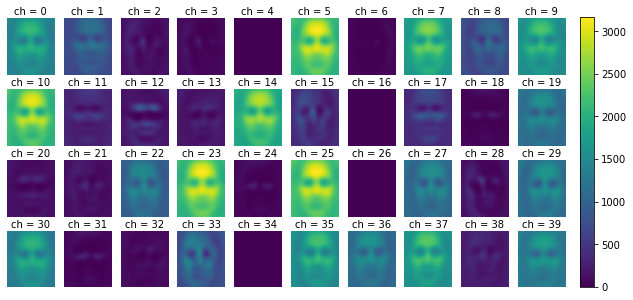

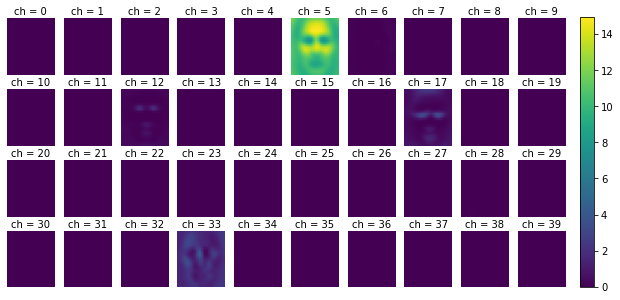

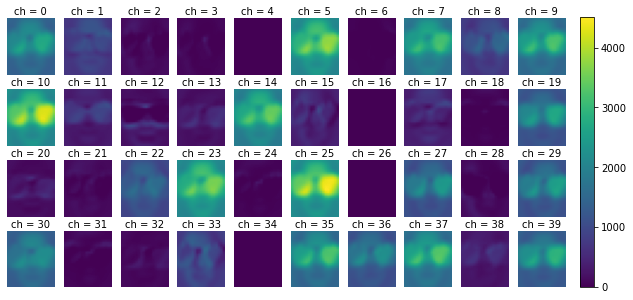

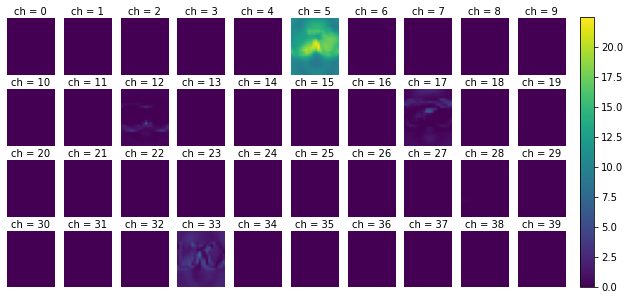

In [ ]:
!mkdir conv3-activations
pathToSave = "/content/conv3-activations/conv3-cl_x_test_bd_model"
visualizeActivations(bd_model,cl_x_test,"conv_2",pathToSave,40)

pathToSave = "/content/conv3-activations/conv3-cl_x_test_fp_model"
visualizeActivations(fp_model,cl_x_test,"conv_2",pathToSave,40)

pathToSave = "/content/conv3-activations/conv3-bd_x_test_bd_model"
visualizeActivations(bd_model,bd_x_test,"conv_2",pathToSave,40)

pathToSave = "/content/conv3-activations/conv3-bd_x_test_fp_model"
visualizeActivations(fp_model,bd_x_test,"conv_2",pathToSave,40)


# pathToSave = "/content/wt-conv3-cl_x_test_bd_model"
# visualizeWeights(bd_model,cl_x_test,"conv_2",pathToSave,40)

# pathToSave = "/content/wt-conv3-cl_x_test_fp_model"
# visualizeWeights(fp_model,cl_x_test,"conv_2",pathToSave,40)

# pathToSave = "/content/wt-conv3-bd_x_test_bd_model"
# visualizeWeights(bd_model,bd_x_test,"conv_2",pathToSave,40)

# pathToSave = "/content/wt-conv3-bd_x_test_fp_model"
# visualizeWeights(fp_model,bd_x_test,"conv_2",pathToSave,40)
!zip -r conv3-activations /content/conv3-activations

In [35]:
!mkdir conv5-activations

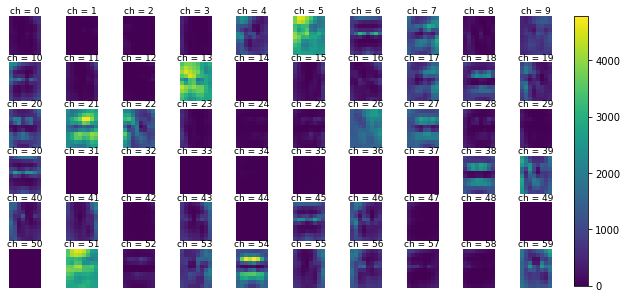

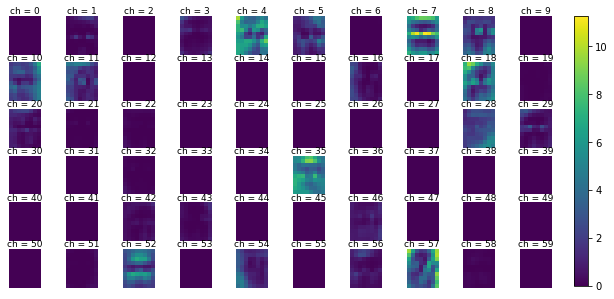

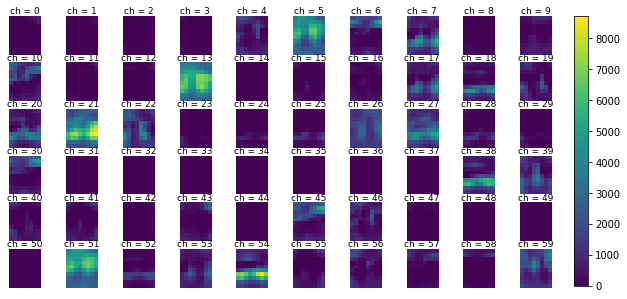

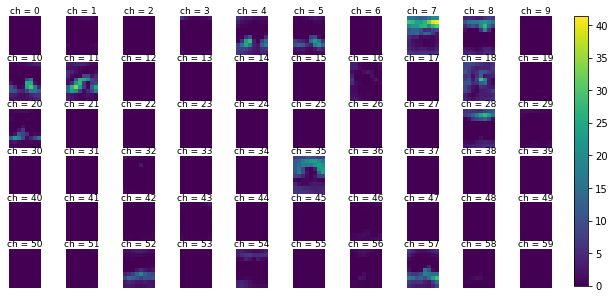

In [43]:
pathToSave = "/content/conv5-activations/conv5-cl_x_test_bd_model"
visualizeActivations(bd_model,cl_x_test,"conv_3",pathToSave,60)

pathToSave = "/content/conv5-activations/conv5-cl_x_test_fp_model"
visualizeActivations(fp_model,cl_x_test,"conv_3",pathToSave,60)

pathToSave = "/content/conv5-activations/conv5-bd_x_test_bd_model"
visualizeActivations(bd_model,bd_x_test,"conv_3",pathToSave,60)

pathToSave = "/content/conv5-activations/conv5-bd_x_test_fp_model"
visualizeActivations(fp_model,bd_x_test,"conv_3",pathToSave,60)


# pathToSave = "/content/wt-conv5-cl_x_test_bd_model"
# visualizeWeights(bd_model,cl_x_test,"conv_3",pathToSave,60)

# pathToSave = "/content/wt-conv5-cl_x_test_fp_model"
# visualizeWeights(fp_model,cl_x_test,"conv_3",pathToSave,60)

# pathToSave = "/content/wt-conv5-bd_x_test_bd_model"
# visualizeWeights(bd_model,bd_x_test,"conv_3",pathToSave,60)

# pathToSave = "/content/wt-conv5-bd_x_test_fp_model"
# visualizeWeights(fp_model,bd_x_test,"conv_3",pathToSave,60)


In [44]:
!zip -r conv5.zip /content/conv5-activations/

  adding: content/conv5-activations/ (stored 0%)
  adding: content/conv5-activations/conv5-cl_x_test_fp_model.png (deflated 40%)
  adding: content/conv5-activations/conv5-cl_x_test_bd_model.png (deflated 37%)
  adding: content/conv5-activations/conv5-bd_x_test_fp_model.png (deflated 39%)
  adding: content/conv5-activations/conv5-bd_x_test_bd_model.png (deflated 35%)


In [ ]:
!zip -r conv5-activations.zip /content/conv5-activations/

  adding: content/conv5-activations/ (stored 0%)
  adding: content/conv5-activations/conv5-cl_x_test_fp_model.png (deflated 34%)
  adding: content/conv5-activations/conv5-cl_x_test_bd_model.png (deflated 31%)
  adding: content/conv5-activations/conv5-bd_x_test_fp_model.png (deflated 36%)
  adding: content/conv5-activations/conv5-bd_x_test_bd_model.png (deflated 30%)


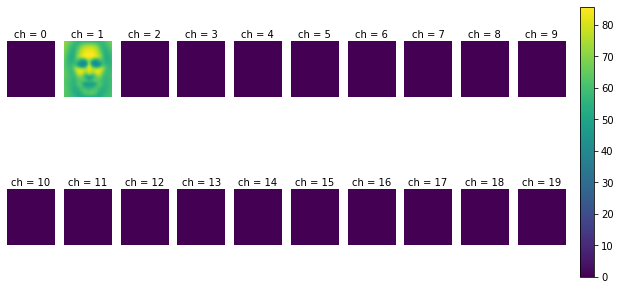

In [ ]:
pathToSave = "/content/conv1-cl_x_test_fp_model"

visualizeActivations(fp_model,cl_x_test,"conv_1",pathToSave,20)

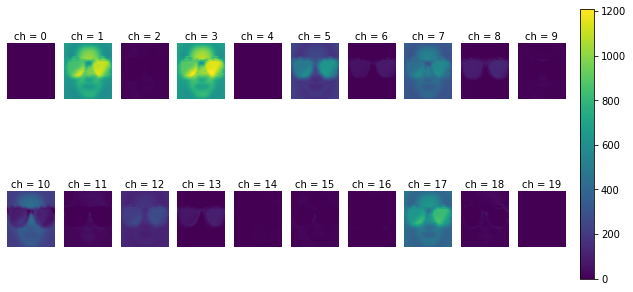

In [ ]:
pathToSave = "/content/conv1-bd_x_test_bd_model"

visualizeActivations(bd_model,bd_x_test,"conv_1",pathToSave,20)

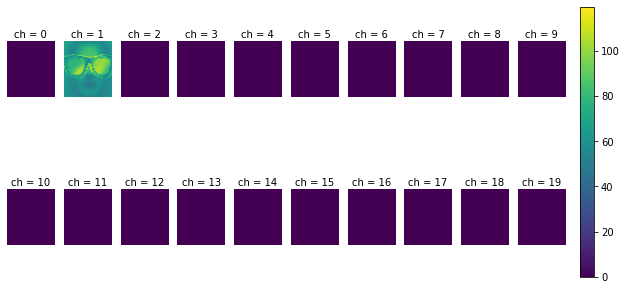

In [ ]:
pathToSave = "/content/conv1-bd_x_test_fp_model"

visualizeActivations(fp_model,bd_x_test,"conv_1",pathToSave,20)

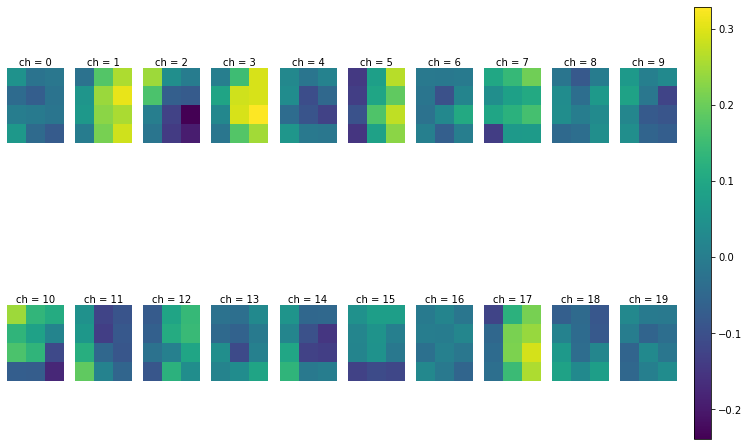

In [ ]:
pathToSave = "/content/act-conv1-cl_x_test_bd_model"

visualizeWeights(bd_model,cl_x_test,"conv_1",pathToSave,20)

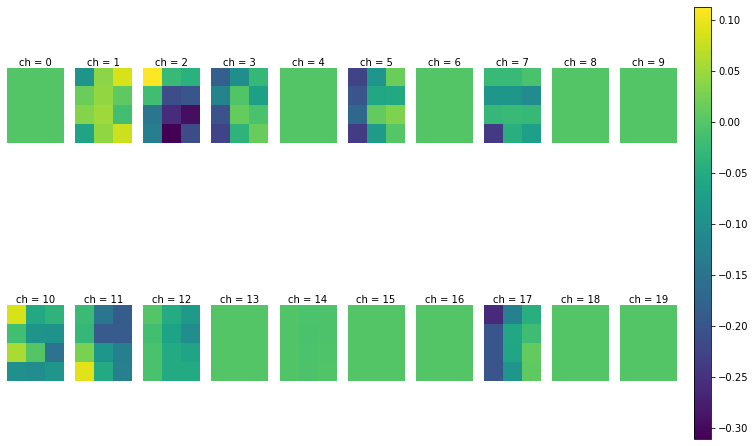

In [ ]:
pathToSave = "/content/act-conv1-cl_x_test_fp_model"

visualizeWeights(fp_model,cl_x_test,"conv_1",pathToSave,20)

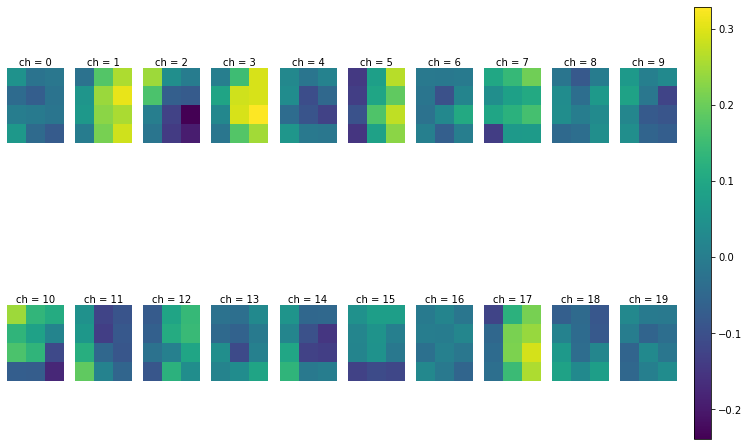

In [ ]:
pathToSave = "/content/act-conv1-bd_x_test_bd_model"

visualizeWeights(bd_model,bd_x_test,"conv_1",pathToSave,20)

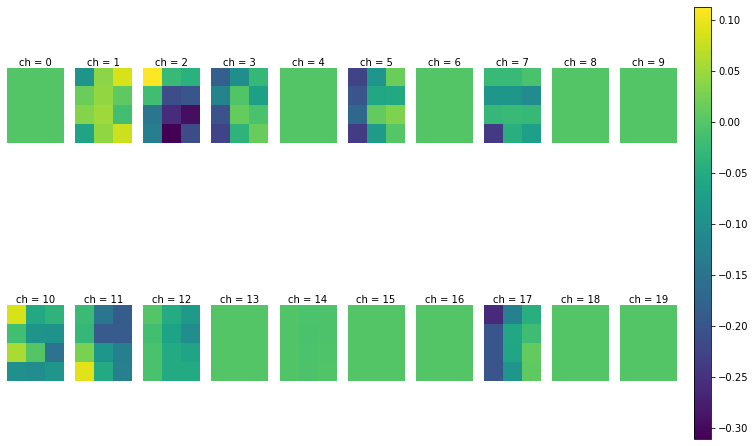

In [ ]:
pathToSave = "/content/act-conv1-cl_x_test_fp_model"

visualizeWeights(fp_model,cl_x_test,"conv_1",pathToSave,20)

CONV - 1 

Visualizing Activation in Layer

Mean Norm of layer :  961809.8
Activation of Weight  0 :  14524.538
Activation of Weight  1 :  4376548.0
Activation of Weight  2 :  162497.1
Activation of Weight  3 :  4619320.0
Activation of Weight  4 :  9630.312
Activation of Weight  5 :  1409068.5
Activation of Weight  6 :  14616.793
Activation of Weight  7 :  2298930.8
Activation of Weight  8 :  47071.926
Activation of Weight  9 :  102410.84
Activation of Weight  10 :  1788103.2
Activation of Weight  11 :  256028.94
Activation of Weight  12 :  870267.1
Activation of Weight  13 :  33622.062
Activation of Weight  14 :  82648.25
Activation of Weight  15 :  136692.77
Activation of Weight  16 :  33395.38
Activation of Weight  17 :  2834594.2
Activation of Weight  18 :  145408.55
Activation of Weight  19 :  816.5945


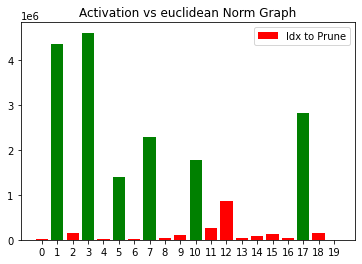

In [ ]:

conv_layer_name = "conv_1"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyact(cl_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
plt.title("Activation vs "+norm_ord+" Norm Graph")
plt.show()

IndexError: ignored

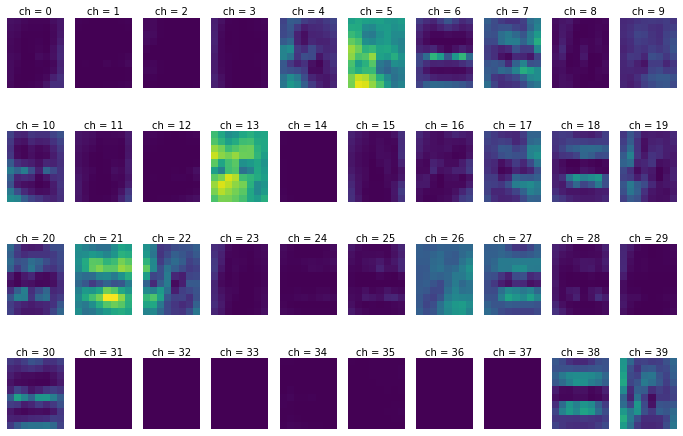

In [ ]:
pathToSave = "/content/conv3-cl_x_test_on backdoored model"
suptitleText = "conv3-activations_on_cl_x_test_on backdoored model"
visualizeActivations(bd_model,cl_x_test,"conv_3",pathToSave,suptitleText,40)



In [ ]:
pathToSave = "/content/conv1-cl_x_test_on backdoored model"
suptitleText = "conv1-activations_on_cl_x_test_on backdoored model"
visualizeActivations(bd_model,cl_x_test,"conv_1",pathToSave,suptitleText,20)

pathToSave = "/content/conv1-bd_x_test on backdoored model"
suptitleText = "conv1-activations on bd_x_test on backdoored model "
visualizeActivations(bd_model,bd_x_test,"conv_1",pathToSave,suptitleText,20)


pathToSave = "/content/conv1-cl_x_test_finepruned model"
suptitleText = "conv1-activations on cl_x_test on finepruned model "
visualizeActivations(fp_model,cl_x_test,"conv_1",pathToSave,suptitleText,20)


pathToSave = "/content/conv1-bd_x_test on finepruned model"
suptitleText = "conv1-activations on bd_x_test on finepruned model "
visualizeActivations(fp_model,bd_x_test,"conv_1",pathToSave,suptitleText,20)


In [ ]:
print("MEAN ACTIVATION THRESHOLDING: ")

print("CONV - 1 Filter Idx below mean when backdoored model is evaluated on clean test data")
print(thresholdbyact(cl_x_test,bd_model,1,20))

print("CONV - 1 Filter Idx below mean when backdoored model is evaluated on poisoned data")
print(thresholdbyact(bd_x_test,bd_model,1,20))

print("CONV - 1 Filter Idx below mean when finepruned model is evaluated on clean test data")
print(thresholdbyact(cl_x_test,fp_model,1,20))

print("CONV - 1 Filter Idx below mean when backdoored model is evaluated on poisoned test data")
print(thresholdbyact(bd_x_test,fp_model,1,20))


Mean Norm of layer :  4375198700.0
Activation of Weight  0 :  11547130.0
Activation of Weight  1 :  20810523000.0
Activation of Weight  2 :  316835200.0
Activation of Weight  3 :  21964694000.0
Activation of Weight  4 :  5357218.5
Activation of Weight  5 :  5861041000.0
Activation of Weight  6 :  7666118.0
Activation of Weight  7 :  10943745000.0
Activation of Weight  8 :  97253930.0
Activation of Weight  9 :  239667700.0
Activation of Weight  10 :  8596234000.0
Activation of Weight  11 :  785530600.0
Activation of Weight  12 :  3819507200.0
Activation of Weight  13 :  36950970.0
Activation of Weight  14 :  138975680.0
Activation of Weight  15 :  310066080.0
Activation of Weight  16 :  43342370.0
Activation of Weight  17 :  13144777000.0
Activation of Weight  18 :  370132800.0
Activation of Weight  19 :  125095.25


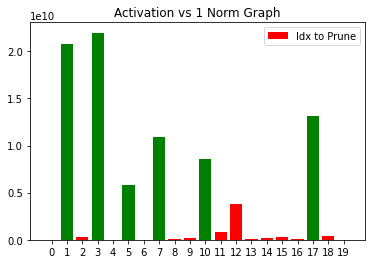

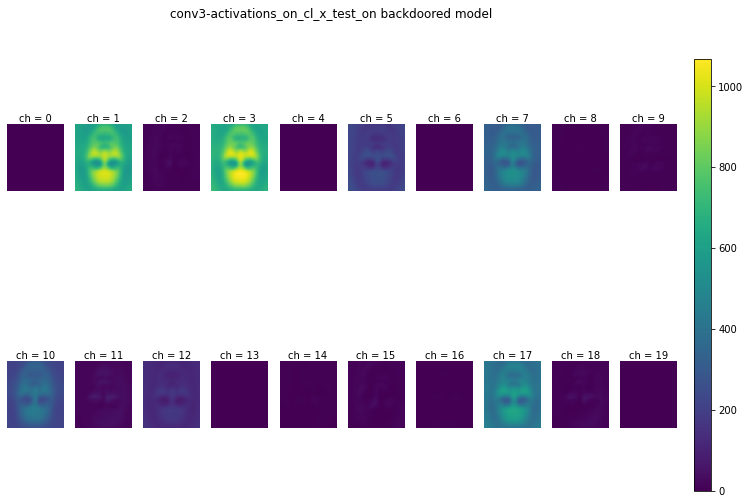

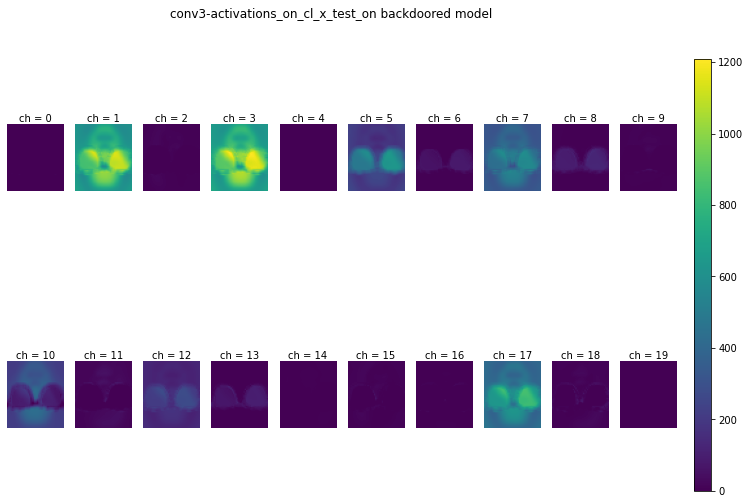

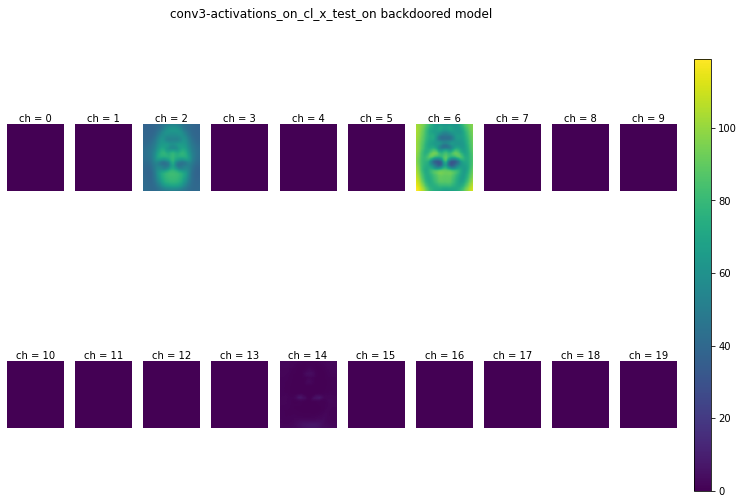

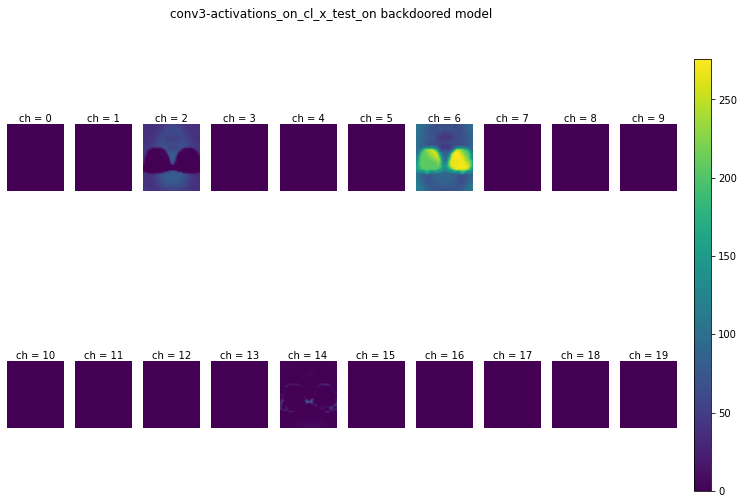

In [ ]:
conv_layer_name = "conv_1"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyact(cl_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
plt.title("Activation vs "+str(norm_ord)+" Norm Graph")
plt.show()

visualizeActivations(bd_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,20)
visualizeActivations(bd_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,20)
visualizeActivations(fp_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,20)
visualizeActivations(fp_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,20)


In [ ]:
#check acc and asr
def calculate_acc(model,x_train,y_train):
  if x_train.shape[0] % 10 ==0: 
    n_split=10
  else:
    n_split = 9 
  x_train=np.array(np.split(x_train,n_split))
  y_pred = []

  for i in range(len(x_train)):
    x_train[i] = tf.convert_to_tensor(x_train[i])
    y_pred.append(np.argmax(model(x_train[i]).numpy(), axis=1))
  y_pred=np.array(y_pred).flatten()
  return np.mean(np.equal(y_pred, y_train)) * 100  

In [ ]:
calculate_acc(bd_model,cl_x_valid,cl_y_valid)

42.25339915129471

In [ ]:
calculate_acc(bd_model,cl_x_test,cl_y_test)

42.361652377240844

In [ ]:
calculate_acc(bd_model,bd_x_test,bd_y_test)

99.92985190958692

Mean Norm of layer :  5367207000.0
Activation of Weight  0 :  9855279000.0
Activation of Weight  1 :  5332658700.0
Activation of Weight  2 :  919747300.0
Activation of Weight  3 :  403833900.0
Activation of Weight  4 :  8086.55
Activation of Weight  5 :  14690388000.0
Activation of Weight  6 :  175598830.0
Activation of Weight  7 :  12087324000.0
Activation of Weight  8 :  4988604000.0
Activation of Weight  9 :  10640841000.0
Activation of Weight  10 :  14350766000.0
Activation of Weight  11 :  2026965000.0
Activation of Weight  12 :  1490655900.0
Activation of Weight  13 :  1252866800.0
Activation of Weight  14 :  13293511000.0
Activation of Weight  15 :  2686853600.0
Activation of Weight  16 :  1526510.5
Activation of Weight  17 :  2985157600.0
Activation of Weight  18 :  274656130.0
Activation of Weight  19 :  7579385300.0
Activation of Weight  20 :  858692600.0
Activation of Weight  21 :  893761300.0
Activation of Weight  22 :  6897811500.0
Activation of Weight  23 :  14729464000.0

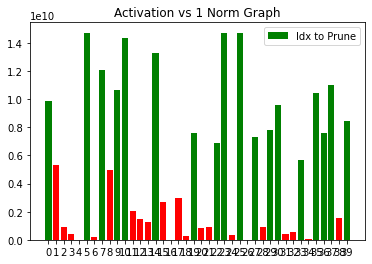

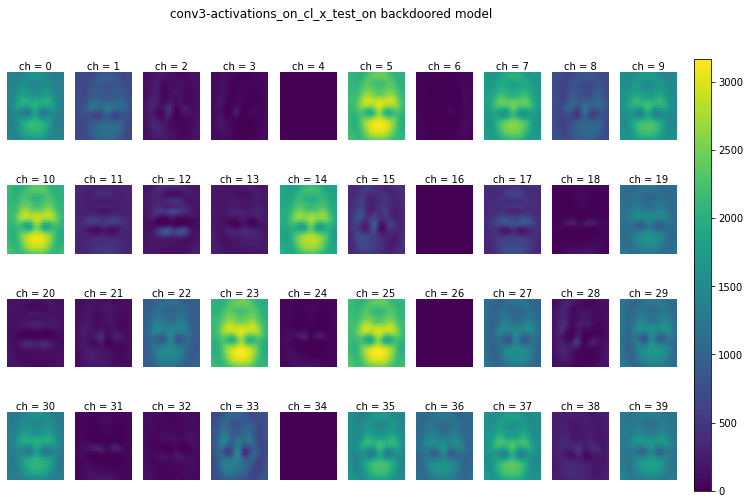

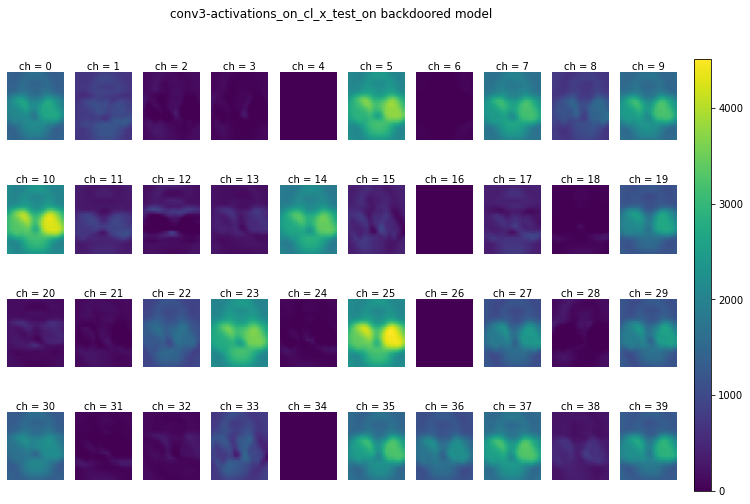

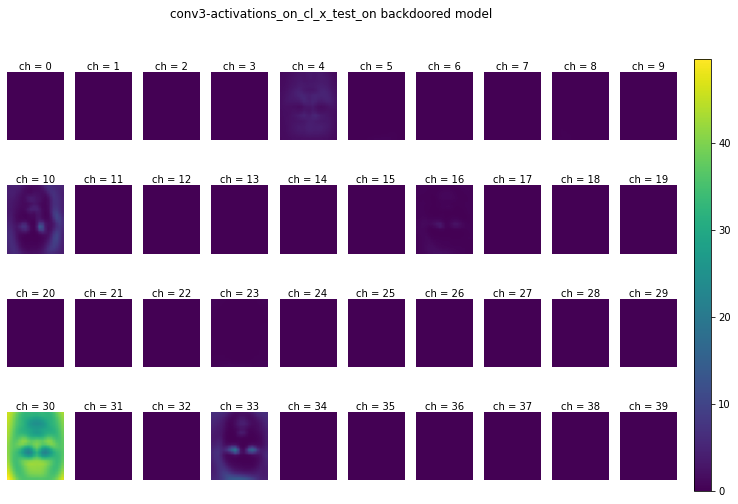

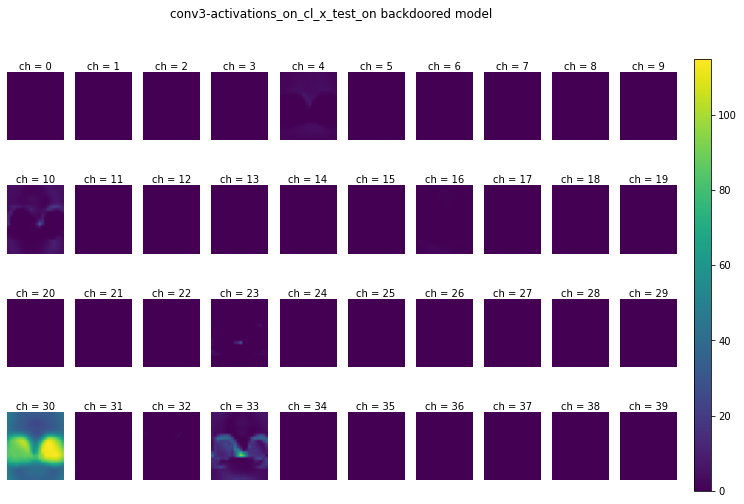

In [ ]:
conv_layer_name = "conv_2"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyact(cl_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
plt.title("Activation vs "+str(norm_ord)+" Norm Graph")
plt.show()

visualizeActivations(bd_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,40)
visualizeActivations(bd_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,40)
visualizeActivations(fp_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,40)
visualizeActivations(fp_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,40)


Mean Norm of layer :  4832.12
Activation of Weight  0 :  186.1943
Activation of Weight  1 :  0.0
Activation of Weight  2 :  12.563323
Activation of Weight  3 :  0.35542777
Activation of Weight  4 :  19509.13
Activation of Weight  5 :  4578.3833
Activation of Weight  6 :  2135.2537
Activation of Weight  7 :  9.816859
Activation of Weight  8 :  552.8138
Activation of Weight  9 :  0.0
Activation of Weight  10 :  14266.708
Activation of Weight  11 :  1.6593802
Activation of Weight  12 :  0.34283954
Activation of Weight  13 :  6.2787056
Activation of Weight  14 :  0.0
Activation of Weight  15 :  0.043087907
Activation of Weight  16 :  4894.5938
Activation of Weight  17 :  0.0
Activation of Weight  18 :  39385.68
Activation of Weight  19 :  983.8002
Activation of Weight  20 :  124.92413
Activation of Weight  21 :  173.77998
Activation of Weight  22 :  0.1771942
Activation of Weight  23 :  2494.506
Activation of Weight  24 :  2244.2454
Activation of Weight  25 :  562.6981
Activation of Weight

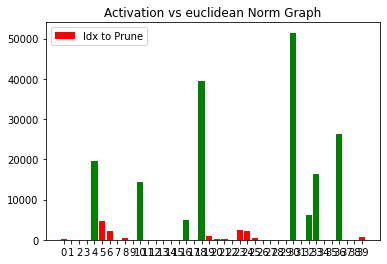

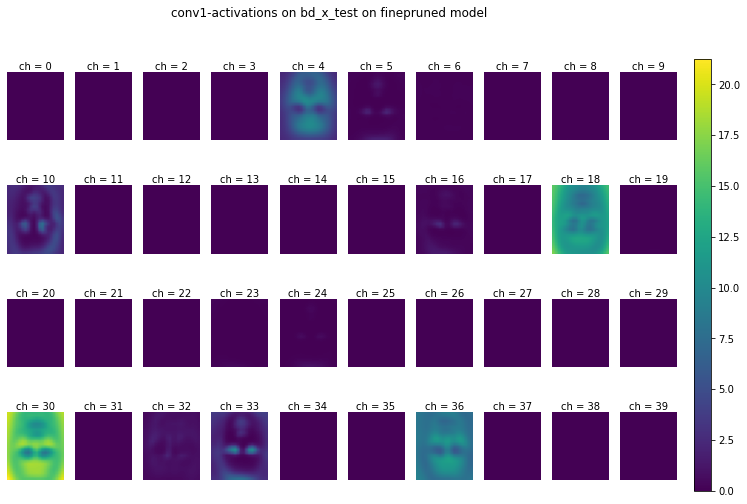

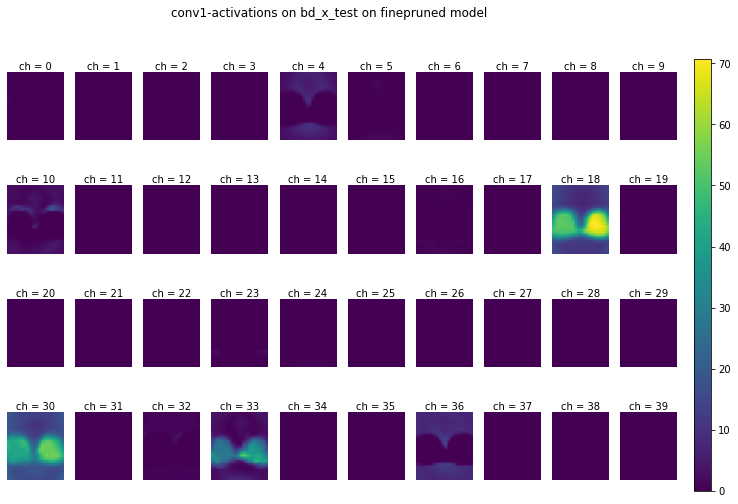

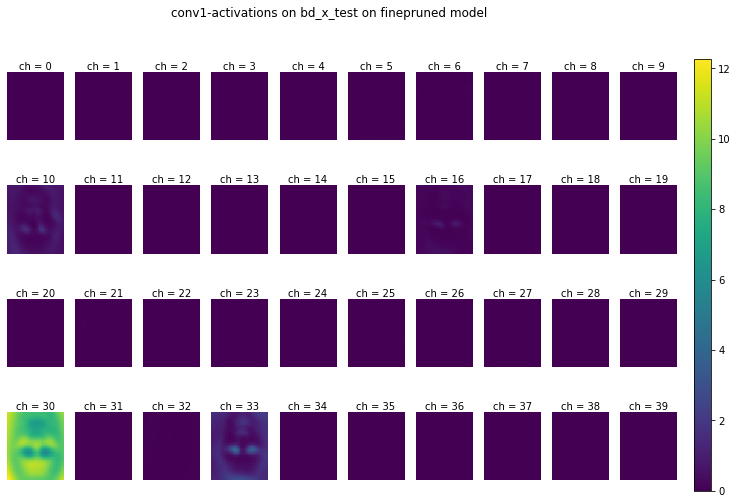

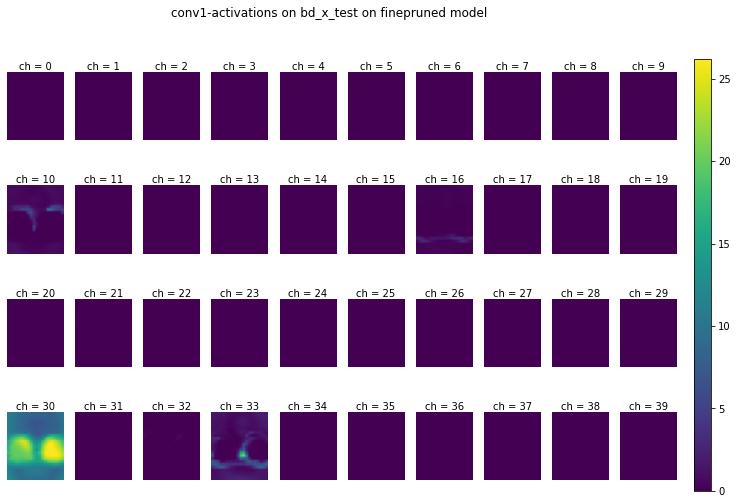

In [ ]:
conv_layer_name = "conv_2"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyact(cl_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
plt.title("Activation vs "+str(norm_ord)+" Norm Graph")
plt.show()

visualizeActivations(bd_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,40)
visualizeActivations(bd_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,40)
visualizeActivations(fp_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,40)
visualizeActivations(fp_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,40)


Mean Norm of layer :  620104.44
Activation of Weight  0 :  0.0
Activation of Weight  1 :  289901.06
Activation of Weight  2 :  0.0
Activation of Weight  3 :  220019.28
Activation of Weight  4 :  2915646.8
Activation of Weight  5 :  900461.2
Activation of Weight  6 :  2574.335
Activation of Weight  7 :  3001973.0
Activation of Weight  8 :  927844.5
Activation of Weight  9 :  0.0
Activation of Weight  10 :  2463667.0
Activation of Weight  11 :  1102042.0
Activation of Weight  12 :  0.0
Activation of Weight  13 :  0.0
Activation of Weight  14 :  0.0
Activation of Weight  15 :  0.0
Activation of Weight  16 :  747166.3
Activation of Weight  17 :  0.0
Activation of Weight  18 :  3006292.2
Activation of Weight  19 :  106071.56
Activation of Weight  20 :  66594.266
Activation of Weight  21 :  31391.121
Activation of Weight  22 :  15574.838
Activation of Weight  23 :  913.50635
Activation of Weight  24 :  0.0
Activation of Weight  25 :  0.0
Activation of Weight  26 :  0.0
Activation of Weight  

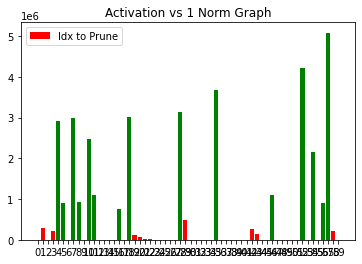

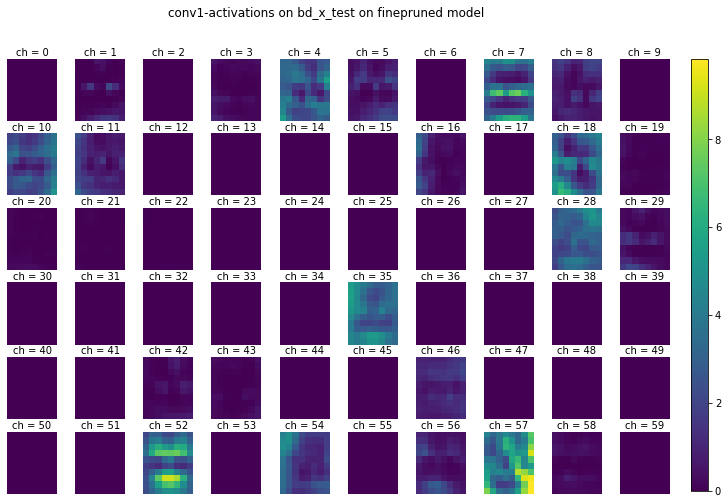

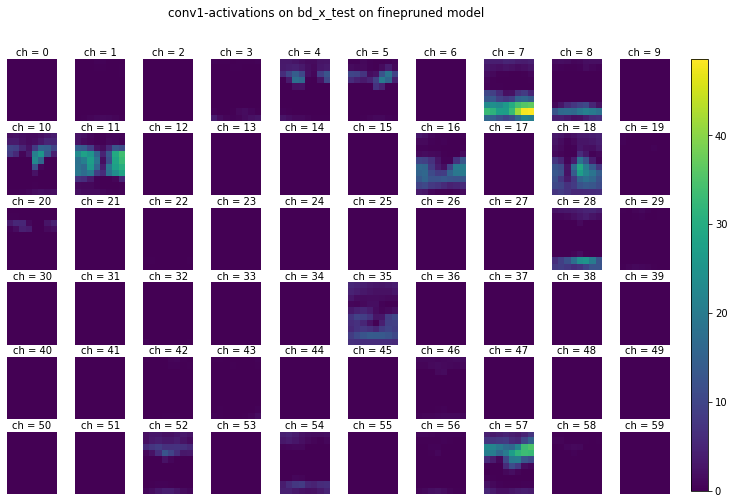

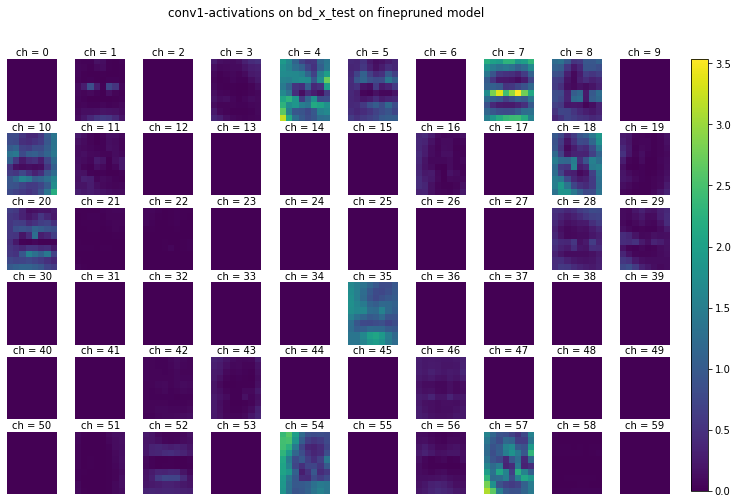

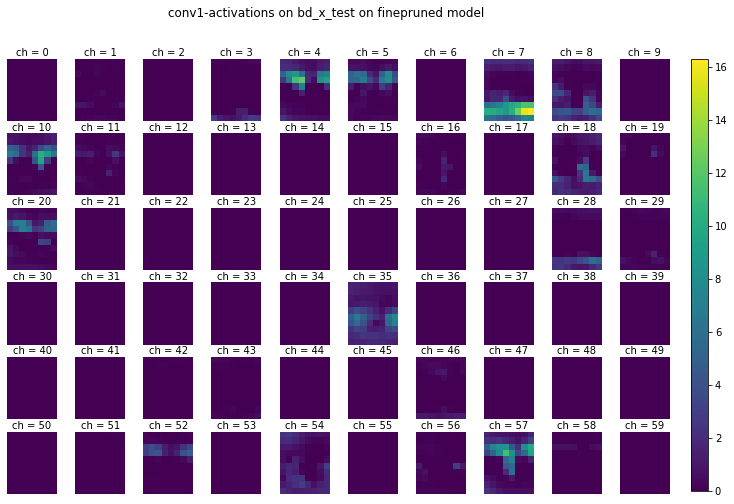

In [ ]:
conv_layer_name = "conv_3"
norm_ord = 1 # euclidean or 1
norms , idxToPrune =thresholdbyact(cl_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
plt.title("Activation vs "+str(norm_ord)+" Norm Graph")
plt.show()

visualizeActivations(bd_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,60)
visualizeActivations(bd_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,60)
visualizeActivations(fp_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,60)
visualizeActivations(fp_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,60)


Mean Norm of layer :  1481.8595
Activation of Weight  0 :  0.0
Activation of Weight  1 :  1938.727
Activation of Weight  2 :  0.0
Activation of Weight  3 :  2022.2189
Activation of Weight  4 :  6338.0767
Activation of Weight  5 :  2740.9446
Activation of Weight  6 :  179.94275
Activation of Weight  7 :  6103.0303
Activation of Weight  8 :  2594.9902
Activation of Weight  9 :  0.0
Activation of Weight  10 :  5289.4297
Activation of Weight  11 :  3303.387
Activation of Weight  12 :  0.0
Activation of Weight  13 :  0.0
Activation of Weight  14 :  0.0
Activation of Weight  15 :  0.0
Activation of Weight  16 :  2805.3804
Activation of Weight  17 :  0.0
Activation of Weight  18 :  6446.2056
Activation of Weight  19 :  830.29297
Activation of Weight  20 :  659.76776
Activation of Weight  21 :  454.7389
Activation of Weight  22 :  512.22314
Activation of Weight  23 :  53.997753
Activation of Weight  24 :  0.0
Activation of Weight  25 :  0.0
Activation of Weight  26 :  0.0
Activation of Weight 

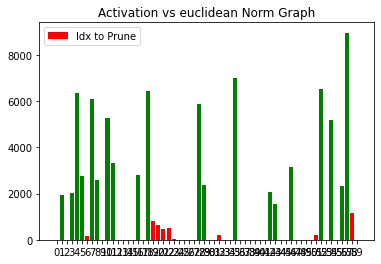

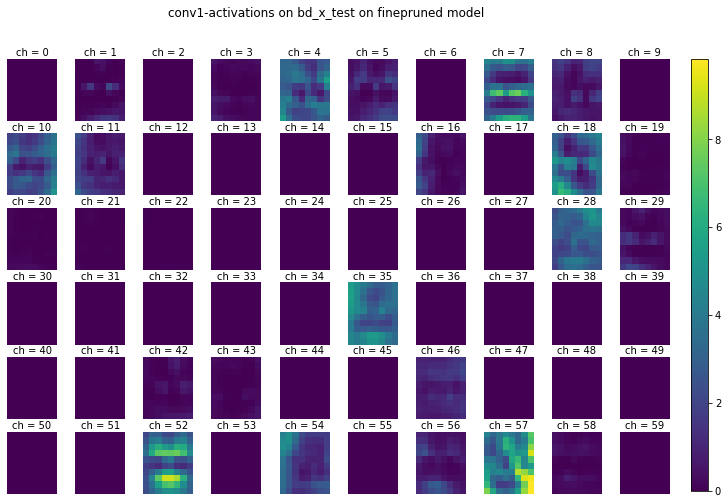

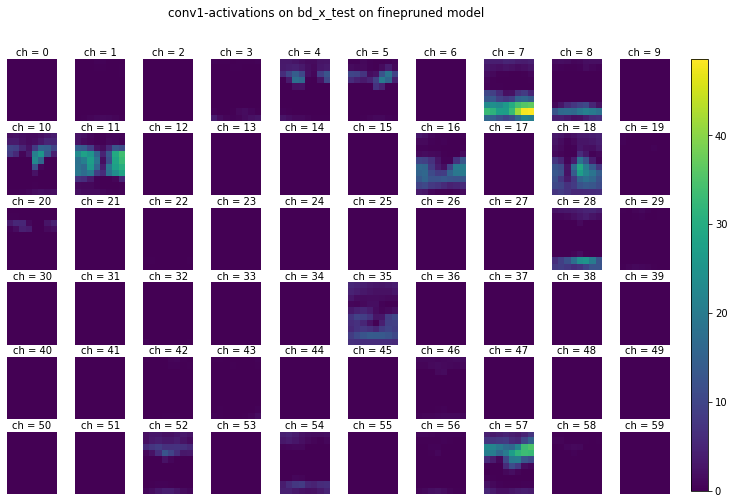

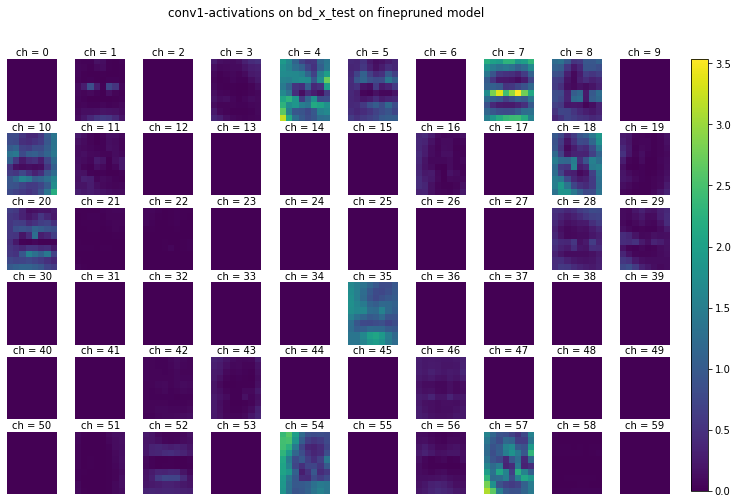

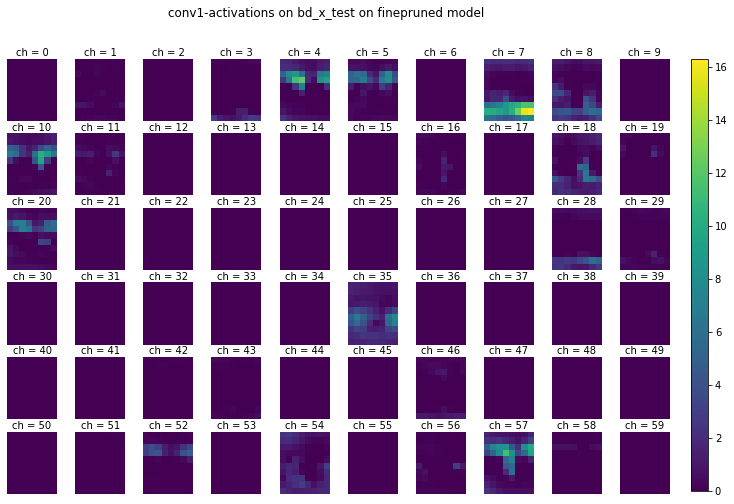

In [ ]:
conv_layer_name = "conv_3"
norm_ord = "euclidean" # euclidean or 1
norms , idxToPrune =thresholdbyact(cl_x_test,bd_model,getLayerIndexByName(bd_model,conv_layer_name),norm_ord)
idx=[i for i in range(len(norms))]
clrs = ['red' if (x < np.mean(norms)) else 'green' for x in norms ]
plt.xticks(idx)
plt.bar(idx,norms, color=clrs)
plt.legend(["Idx to Prune"])
plt.title("Activation vs "+str(norm_ord)+" Norm Graph")
plt.show()

visualizeActivations(bd_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,60)
visualizeActivations(bd_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,60)
visualizeActivations(fp_model,cl_x_test,conv_layer_name,pathToSave,suptitleText,60)
visualizeActivations(fp_model,bd_x_test,conv_layer_name,pathToSave,suptitleText,60)


In [ ]:
layer_weights = bd_model.get_layer('conv_1').get_weights()[0]



In [ ]:
layer_norm = []
for i in range(layer_weights[0].shape[-1]):
  layer_norm.append(tf.norm(layer_weights[0][:,:,i],ord="euclidean").numpy())

In [ ]:
layer_norm[6]

0.15131916

In [ ]:
layer_norm = np.array(layer_norm)
print(layer_norm.mean())

np.argsort(layer_norm)

0.17375052


array([ 4, 16,  2,  1, 17, 12, 11,  0,  9, 13,  6,  5,  7, 15, 14, 18,  3,
        8, 10, 19])

In [ ]:
for i in range(layer_weights[0].shape[-1])

In [ ]:
def get_prune_data(backdoored_model,prune_method):
  if prune_method not in {"layerwise-l1norm","layerwise-l2norm","global-l1norm","global-l2norm"}:
    raise ValueError('Invalid `pruning method`')

  conv_layers={'conv_1':1,'conv_2':3,'conv_3':5} #_name of conv layers to be pruned
  weights = []
  prune_dict ={"prune method " : prune_method,
              "conv layers ": conv_layers,
              "norms" :{},
              "layerwise_norm_mean":{},
              "idx to prune":{}
              }
  for conv_layer_name,conv_layer_idx in conv_layers.items():
    # print(conv_layer_name,conv_layer_idx)

    layer_weights = backdoored_model.get_layer(conv_layer_name).get_weights()
    norms=[]
    for i in range(layer_weights[0].shape[-1]):
      if prune_method == "layerwise-l2norm":
        norms.append(tf.norm(layer_weights[0][:,:,:,i],ord="euclidean").numpy())
      elif prune_method == "layerwise-l1norm":
        norms.append(tf.norm(layer_weights[0][:,:,:,i],ord=1).numpy())

    prune_dict["norms"][conv_layer_idx]= norms
    prune_dict["layerwise_norm_mean"][conv_layer_idx]= np.array(norms).mean()
    


  for conv_layer_idx in prune_dict['norms']:
    idx_to_prune=[]
    for kernel_norm_idx in range(len(prune_dict['norms'][conv_layer_idx])):
      
      if prune_dict['layerwise_norm_mean'][conv_layer_idx]< prune_dict['norms'][conv_layer_idx][kernel_norm_idx]:
        idx_to_prune.append(kernel_norm_idx)
    prune_dict['idx to prune'][conv_layer_idx]=idx_to_prune
  
  a_file = open("/content/"+prune_method+"-prune-data.pkl", "wb")
  pickle.dump(prune_dict, a_file)
  a_file.close()
  return prune_dict



In [ ]:
pruning_methods = ["layerwise-l1norm","layerwise-l2norm","global-l1norm","global-l2norm"]
prune_dict = get_prune_data(backdoored_model,"layerwise-l1norm")








  

In [ ]:
backdoored_model.layers[1].get_weights()[0].shape[-1]

20

In [ ]:
prune_dict["idx to prune"]

{1: [3, 5, 8, 10, 14, 18, 19],
 3: [2, 3, 5, 6, 8, 10, 16, 19, 20, 21, 23, 25, 29, 31, 32, 33, 39],
 5: [1,
  3,
  4,
  5,
  6,
  7,
  8,
  10,
  11,
  16,
  18,
  19,
  20,
  21,
  22,
  23,
  28,
  29,
  32,
  35,
  39,
  42,
  43,
  46,
  51,
  52,
  54,
  56,
  57,
  58]}

In [ ]:
global_mean = []
for i in prune_dict["norms"]:
  for j in prune_dict["norms"][i]:
    global_mean.append(j)
print(np.array(global_mean).flatten().mean())

12.77597


In [ ]:
np.array(layer_weights[0]).flatten().shape

(21600,)

In [ ]:
layer_weights=backdoored_model.get_layer('conv_1').get_weights()
print(tf.norm(layer_weights[0].flatten(),ord="euclidean"))


tf.Tensor(2.0188012, shape=(), dtype=float32)


In [ ]:
layer_weights[0][:,:,:,0].mean()

-0.029292382

In [ ]:
import pickle


a_file = open("/content/layerwise-l2norm-prune-data.pkl", "wb")
pickle.dump(prune_dict, a_file)
a_file.close()

a_file = open("/content/layerwise-l2norm-prune-data.pkl", "rb")
output = pickle.load(a_file)
print(output)


{'prune method ': 'layerwise-l2norm', 'conv layers ': {'conv_1': 1, 'conv_2': 3, 'conv_3': 5}, 'norms': {1: [0.22974834, 0.10491801, 0.1081355, 0.53014064, 0.067800835, 0.40086606, 0.30004358, 0.26412705, 1.0501739, 0.31134713, 0.7971708, 0.21240115, 0.1846279, 0.30068436, 0.3790334, 0.3171228, 0.089562245, 0.11671068, 0.5788059, 0.88778126], 3: [0.86409396, 0.3622952, 1.2896388, 1.4183878, 0.960865, 2.3690264, 2.1020248, 0.8442326, 2.4063842, 0.16031535, 1.2274175, 0.59341455, 1.0012231, 0.7805924, 0.32963362, 0.28863975, 1.614779, 0.65876746, 0.68042535, 1.7049025, 1.9651746, 1.3025334, 1.0277898, 1.2796973, 0.8782859, 1.9151236, 0.38126743, 0.30662528, 0.69890827, 1.3296165, 0.9064629, 1.8462039, 1.6654202, 1.0860597, 0.5278583, 0.68421197, 0.78263324, 0.87498033, 0.29264194, 1.6440668], 5: [0.21963568, 2.3962357, 1.2653407, 2.6618862, 1.9766304, 1.9911213, 1.9570098, 1.7916394, 1.747853, 1.004379, 1.7249777, 1.7745372, 0.7666546, 0.66958445, 0.23263142, 0.6435946, 2.481443, 0.18329

In [ ]:
def evaluate_model(model,X_train,Y_train,X_test=None,Y_test=None):
  